<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-feature_engineering_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install ipywidgets==8.0.2
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install pyarrow==10.0.0
!pip install optuna==3.0.3
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1
!pip install shap==0.41.0
!pip install wandb==0.13.4


     |████████████████████████████████| 76.7 MB 29.3 MB/s eta 0:00:01    |██████▏                         | 14.9 MB 6.4 MB/s eta 0:00:10
     |████████████████████████████████| 15.3 MB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 1.0 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 25.0 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 161 kB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 22.4 MB/s eta 0:00:01
     |████████████████████████████████| 262 kB 19.0 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 26.1 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 408 kB 31.5 MB/s eta 0:00:01
ERROR: google-api-core 2.10.2 has req

In [2]:
import os
import random

from catboost import CatBoostClassifier, Pool

import gcsfs
# import google.auth
# from google.colab import auth, output

import numpy as np
import pandas as pd
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import seaborn as sns
import shap

from tqdm.notebook import tqdm
import wandb


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="baseline", entity="fbv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
# init shap
shap.initjs()

In [6]:
# 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/root/.config/gcloud/application_default_credentials.json"


# credentials, _ = google.auth.default()
# fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)

fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"


Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.


In [7]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)


seed = 42
seed_everything(seed)


In [8]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet"
)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet"
)
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet"
)


In [9]:
train.head(10)


,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
5,YHOO,2005-05-02 09:30:03,73595,YHQ,2005-10-22,35.0,P,26,3.00,2.95,...,2.90,1133.0,256.0,3.10,3.40,24020608.0,46.0,3.10,3.40,-1
6,MATK,2005-05-02 09:30:03,80182,KQT,2005-09-17,65.0,C,2,0.55,0.30,...,0.30,56.0,10.0,0.45,0.45,23989792.0,2.0,0.65,0.45,1
7,VTSS,2005-05-02 09:30:04,80469,VQT,2005-10-22,5.0,P,10,2.75,2.70,...,2.70,10.0,52.0,2.90,2.90,24019950.0,40.0,2.90,2.90,-1
8,ADRX,2005-05-02 09:30:04,80342,QAX,2005-09-17,25.0,C,1,0.60,0.45,...,0.45,94.0,25.0,0.55,0.50,23983374.0,11.0,0.65,0.50,1
9,IVGN,2005-05-02 09:30:04,97063,IUV,2005-08-20,65.0,C,10,11.00,0.00,...,NaN,NaN,NaN,13.80,9.90,23797976.0,10.0,13.80,9.90,1


In [10]:
# randomly sample frac of rows
# frac = 0.02

# train = train.sample(frac=frac, random_state=seed)
# val = val.sample(frac=frac, random_state=seed)
# test = test.sample(frac=frac, random_state=seed)

# unify for common preprocessing
X = pd.concat([train, val, test])


In [11]:
# calculate days to maturity
X["time_to_maturity"] = (X["EXPIRATION"] - X["QUOTE_DATETIME"]).dt.days

In [12]:
# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)

# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)

seconds_in_day = 24*60*60

seconds = (X["QUOTE_DATETIME"] - X["QUOTE_DATETIME"].dt.normalize()).dt.total_seconds()

X["date_time_sin"] = np.sin(2*  np.pi* seconds / seconds_in_day)
X["date_time_cos"] = np.cos(2 * np.pi* seconds / seconds_in_day)

# add year
X["date_year"] = (X["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

date_columns = ["date_month_sin", "date_month_cos","date_time_sin", "date_time_cos", "date_year"]


In [13]:
X.dtypes


UNDERLYING_SYMBOL            object
QUOTE_DATETIME       datetime64[ns]
SEQUENCE_NUMBER               int64
ROOT                         object
EXPIRATION           datetime64[ns]
STRK_PRC                    float32
OPTION_TYPE                category
TRADE_SIZE                    int64
TRADE_PRICE                 float32
BEST_BID                    float32
BEST_ASK                    float32
order_id                      int64
ask_ex                      float32
bid_ex                      float32
bid_size_ex                 float32
ask_size_ex                 float32
price_all_lead              float32
price_all_lag               float32
optionid                    float32
day_vol                     float32
price_ex_lead               float32
price_ex_lag                float32
buy_sell                       int8
time_to_maturity              int64
date_month_sin              float64
date_month_cos              float64
date_time_sin               float64
date_time_cos               

In [14]:
# remove problematic features -> see notebook on aversarial validation
X = X.drop(
    ["SEQUENCE_NUMBER", "order_id", "optionid", "EXPIRATION", "QUOTE_DATETIME", "ROOT", "UNDERLYING_SYMBOL"],
    axis=1,
)


In [15]:
# isolate target
y = X[["buy_sell"]]
X = X.drop(["buy_sell"], axis=1)


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


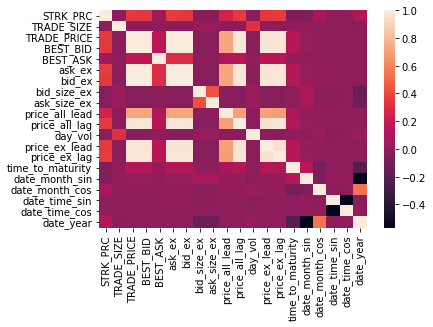

In [16]:
corr = X.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)


In [17]:
# manual deletion of columns that are highly correlated with other columns
X = X.drop(
    ["day_vol", "BEST_ASK", "BEST_BID", "price_all_lead", "price_all_lag"],
    axis=1,
)

In [18]:
# Midspread
mid = 0.5 * (X["ask_ex"] + X["bid_ex"])
# X["mid_ex"] = mid

In [19]:
# Absolute distance from mid
X["abs_mid_ex"] = X["TRADE_PRICE"] - mid

In [20]:
# Degree how much trade size is filled
X["rel_bid_size_ex"] = X["TRADE_SIZE"] / X["bid_size_ex"]
X["rel_ask_size_ex"] = X["TRADE_SIZE"] / X["ask_size_ex"]


In [21]:
# Calculate change similar to tick rule
X["chg_ex_lead"] = X["TRADE_PRICE"] - X["price_ex_lead"]

# Calculate change similar to reverse tick rule
X["chg_ex_lag"] = X["TRADE_PRICE"] - X["price_ex_lag"]

In [22]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = X.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# binarize categorical similar to Borisov et al.
X[cat_columns] = X[cat_columns].apply(lambda x: pd.factorize(x)[0])


['OPTION_TYPE']


In [23]:
# treat inf as nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# Do not fill, let CatBoost Handle NaNs
# X = X.fillna(0)

In [24]:
# separate again for training scaling
X_train = X.loc[train.index, :]
X_val = X.loc[val.index, :]
X_test = X.loc[test.index, :]

y_train = y.loc[train.index, :]
y_val = y.loc[val.index, :]
y_test = y.loc[test.index, :]


In [25]:
# Standardize numerical values
num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns = [x for x in num_columns if x not in date_columns]

# use scaler due to outlying observations > dataset notebook.
scaler = StandardScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])


## CatBoost Baseline 🐈‍⬛

### Hyperparameter Search Baseline🗃️

In [26]:
def objective(trial: optuna.Trial):
    # See docs for recommendations on tuning hyperparameters
    #  https://catboost.ai/en/docs/concepts/parameter-tuning
    iterations = trial.suggest_int("iterations", 10, 1000, log=False)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 1, log=True)
    random_strength = trial.suggest_float("random_strength", 1e-9, 10, log=True)
    depth = trial.suggest_int("depth", 1, 8, log=False)
    grow_policy = trial.suggest_categorical(
        "grow_policy", ["SymmetricTree", "Depthwise"]
    )
    params = {
        "iterations": iterations,
        "depth": depth,
        "grow_policy": grow_policy,
        "learning_rate": learning_rate,
        "random_strength": random_strength,
        "od_type": "Iter",
        "logging_level": "Silent",
        "task_type": "GPU",
        "cat_features":cat_columns,
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train,
        y_train,
    )

    y_pred = model.predict(X_val, prediction_type="Class")
    return accuracy_score(y_val, y_pred)


In [27]:
wandb_kwargs = {"project": "thesis"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)


WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.


In [28]:
# Implement hyperparameter search
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=seed),
    study_name="baseline_gbm",
)
study.optimize(objective, n_trials=200, callbacks=[wandbc])


[I 2022-11-06 05:07:23,835] A new study created in memory with name: baseline_gbm
iteritems is deprecated and will be removed in a future version. Use .items instead.
[I 2022-11-06 05:08:17,258] Trial 0 finished with value: 0.7287355148079441 and parameters: {'iterations': 381, 'learning_rate': 0.7701798297509621, 'random_strength': 0.020890047049266662, 'depth': 5, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.7287355148079441.
iteritems is deprecated and will be removed in a future version. Use .items instead.
[I 2022-11-06 05:08:46,013] Trial 1 finished with value: 0.7240531818474466 and parameters: {'iterations': 67, 'learning_rate': 0.49211578692512997, 'random_strength': 0.001026006512489678, 'depth': 6, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.7287355148079441.
iteritems is deprecated and will be removed in a future version. Use .items instead.
[I 2022-11-06 05:09:52,352] Trial 2 finished with value: 0.7057248935119135 and parameters: {'iterati

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
[W 2022-11-06 12:11:56,299] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


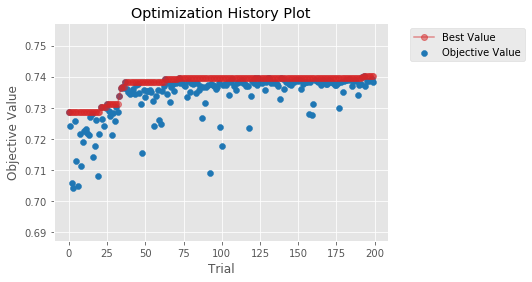

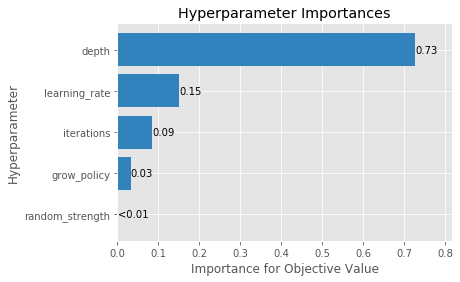

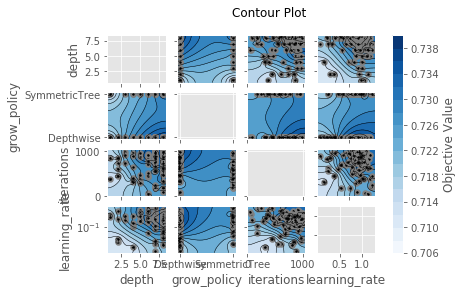

In [29]:
ax_history = optuna.visualization.matplotlib.plot_optimization_history(study)
ax_param_importance = optuna.visualization.matplotlib.plot_param_importances(study)
fig_contour = optuna.visualization.matplotlib.plot_contour(
    study, ["iterations", "depth", "grow_policy", "learning_rate"]
)


In [30]:
print(f"Number of finished trials: {len(study.trials)}")

trial = study.best_trial

print(f"Best trial: {trial}")

print(f"Value: {trial.value}")

print("Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")


Number of finished trials: 200
Best trial: FrozenTrial(number=193, values=[0.7401879869823088], datetime_start=datetime.datetime(2022, 11, 6, 11, 52, 8, 926698), datetime_complete=datetime.datetime(2022, 11, 6, 11, 54, 51, 953615), params={'iterations': 964, 'learning_rate': 0.27811017269313026, 'random_strength': 1.6108256704626492e-08, 'depth': 8, 'grow_policy': 'Depthwise'}, distributions={'iterations': IntDistribution(high=1000, log=False, low=10, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.005, step=None), 'random_strength': FloatDistribution(high=10.0, log=True, low=1e-09, step=None), 'depth': IntDistribution(high=8, log=False, low=1, step=1), 'grow_policy': CategoricalDistribution(choices=('SymmetricTree', 'Depthwise'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=193, state=TrialState.COMPLETE, value=None)
Value: 0.7401879869823088
Params:
iterations: 964
learning_rate: 0.27811017269313026
random_strength: 1.6108256704626492e-08
d

In [ ]:
# use CPU to plot learning curves
# see https://catboost.ai/en/docs/concepts/python-reference_catboost_fit
static_params = {"od_type": "Iter", "logging_level": "Silent", "task_type": "CPU","cat_features":cat_columns}

params = {**static_params, **trial.params}
print(params)


In [ ]:
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, plot=True)


In [ ]:
# use shap instead of feature importance to maintain consistency throughout the work
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_columns))
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)
acc_test = model.score(X_test, y_test)

print(f"Accuracy (train): {acc_train}, (val) {acc_val}, and (test) {acc_test}")


### Robustness Baseline🥊

In [ ]:
# Copy unscaled columns
X_print = test.copy()

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = 0 # model.predict(X_test)

# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)
X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2005, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

bins_ttm = [0, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)

# TODO: Security type
# TODO: Moneyness
# TODO: time from previous trade; same underlying or any?


In [ ]:
def check_robustness(criterion: str = "year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule		Baseline
    TRADE_SIZE_binned
    (0,1]	  0.710966
    (1,3]	  0.717664
    (3,5]	  0.715195
    (5,11]	0.699428
    >11	  	0.688348

    Args:
        criterion (str, optional): criterion to check robustness for.
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and
        criterion values in rows.
    """
    results = (
        X_print.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
    )
    return results


In [ ]:
check_robustness("year_binned")


In [ ]:
check_robustness("OPTION_TYPE")


In [ ]:
check_robustness("TRADE_SIZE_binned")


In [ ]:
check_robustness("ttm_binned")


## Classical rules

In [ ]:
# tick rule
# FIXME: Discuss with Grauer et al what is used in table 9 ISE. Probably all lag?
tt = np.where(X_print["TRADE_PRICE"] > X_print["price_all_lag"], 1.0, -1.0)
X_print["buy_sell_predicted"] = tt
X_print["rule"] = "tick rule"

In [ ]:
check_robustness("year_binned")

In [ ]:
# reverse tick rule
X_print["buy_sell_predicted"] = np.where(X_print["TRADE_PRICE"] > X_print["price_all_lag"], 1.0, -1.0)
X_print["rule"] = "reverse tick rule"

In [ ]:
check_robustness("year_binned")

In [ ]:
# quote rule
mid = 0.5 * (X_print["ask_ex"] + X_print["bid_ex"])
qr = np.where(X_print["TRADE_PRICE"] > mid, 1, np.where(X_print["TRADE_PRICE"] < mid, -1, np.nan))
X_print["buy_sell_predicted"] = qr

# fill others random
X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
    lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
)

X_print["rule"] = "quote rule"

In [ ]:
check_robustness("year_binned")

In [ ]:
# trade size tick rule
ts_eq_bid = X_print["TRADE_SIZE"] == X_print["bid_size_ex"]
ts_eq_ask = X_print["TRADE_SIZE"] == X_print["ask_size_ex"]

X_print["buy_sell_predicted"] = np.where(
    ts_eq_bid, 1.0, np.where(ts_eq_ask, -1.0, tt)
)
X_print["rule"] = "trade size + tick rule"

In [ ]:
check_robustness("year_binned")

In [ ]:
X_print["buy_sell_predicted"] = np.where(
    ts_eq_bid, 1.0, np.where(ts_eq_ask, -1.0, qr)
)

# fill others random
X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
    lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
)

X_print["rule"] = "trade size + quote rule"

In [ ]:
check_robustness("year_binned")

In [ ]:
# depth rule p. 14
dr = np.where(
    (X_print["TRADE_PRICE"] == mid) & (X_print["ask_size_ex"] > X_print["bid_size_ex"]),
    1,
    np.where(
        (X_print["TRADE_PRICE"] == mid) & (X_print["ask_size_ex"] < X_print["bid_size_ex"]), -1, np.nan
    ),
)
X_print["buy_sell_predicted"] = dr

X_print["rule"] = "depth rule"

In [ ]:
X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
    lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
)

In [ ]:
check_robustness("year_binned")

In [ ]:
X_print["buy_sell_predicted"] = np.where(
    ts_eq_bid, 1.0, np.where(ts_eq_ask, -1.0, dr)
)

X_print["rule"] = "trade size + depth rule"

In [ ]:
X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
    lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
)

In [ ]:
check_robustness("year_binned")

## Classical Rules Sklearn Implementation 📦

In [ ]:
%%script false --no-raise-error

import warnings
import numpy as np
import scipy.sparse as sp

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import MultiOutputMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import check_consistent_length
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.random import _random_choice_csc
from sklearn.utils.multiclass import class_distribution


class TRClassifier(MultiOutputMixin, ClassifierMixin, BaseEstimator):

    def __init__(self, *, strategy="standard", random_state=None, constant=None):
        self.strategy = strategy
        self.random_state = random_state
        self.constant = constant

    def fit(self, X, y, sample_weight=None):
        """Fit the baseline classifier.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        allowed_strategies = ("standard", "tradesize")

        if self.strategy not in allowed_strategies:
            raise ValueError(
                "Unknown strategy type: %s, expected one of %s."
                % (self.strategy, allowed_strategies)
            )

        self._strategy = self.strategy

        if self._strategy == "uniform" and sp.issparse(y):
            y = y.toarray()
            warnings.warn(
                "A local copy of the target data has been converted "
                "to a numpy array. Predicting on sparse target data "
                "with the uniform strategy would not save memory "
                "and would be slower.",
                UserWarning,
            )

        self.sparse_output_ = sp.issparse(y)

        if not self.sparse_output_:
            y = np.asarray(y)
            y = np.atleast_1d(y)

        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))

        self.n_outputs_ = y.shape[1]

        check_consistent_length(X, y)

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X)

        if self._strategy == "constant":
            if self.constant is None:
                raise ValueError(
                    "Constant target value has to be specified "
                    "when the constant strategy is used."
                )
            else:
                constant = np.reshape(np.atleast_1d(self.constant), (-1, 1))
                if constant.shape[0] != self.n_outputs_:
                    raise ValueError(
                        "Constant target value should have shape (%d, 1)."
                        % self.n_outputs_
                    )

        (self.classes_, self.n_classes_, self.class_prior_) = class_distribution(
            y, sample_weight
        )

        if self._strategy == "constant":
            for k in range(self.n_outputs_):
                if not any(constant[k][0] == c for c in self.classes_[k]):
                    # Checking in case of constant strategy if the constant
                    # provided by the user is in y.
                    err_msg = (
                        "The constant target value must be present in "
                        "the training data. You provided constant={}. "
                        "Possible values are: {}.".format(
                            self.constant, list(self.classes_[k])
                        )
                    )
                    raise ValueError(err_msg)

        if self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]
            self.class_prior_ = self.class_prior_[0]

        return self

    def predict(self, X):
        """Perform classification on test vectors X.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data.
        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Predicted target values for X.
        """
        check_is_fitted(self)

        # numpy random_state expects Python int and not long as size argument
        # under Windows
        n_samples = _num_samples(X)
        rs = check_random_state(self.random_state)

        n_classes_ = self.n_classes_
        classes_ = self.classes_
        class_prior_ = self.class_prior_
        constant = self.constant
        if self.n_outputs_ == 1:
            # Get same type even for self.n_outputs_ == 1
            n_classes_ = [n_classes_]
            classes_ = [classes_]
            class_prior_ = [class_prior_]
            constant = [constant]
        # Compute probability only once
        if self._strategy == "stratified":
            proba = self.predict_proba(X)
            if self.n_outputs_ == 1:
                proba = [proba]

        if self.sparse_output_:
            class_prob = None
            if self._strategy in ("most_frequent", "prior"):
                classes_ = [np.array([cp.argmax()]) for cp in class_prior_]

            elif self._strategy == "stratified":
                class_prob = class_prior_

            elif self._strategy == "uniform":
                raise ValueError(
                    "Sparse target prediction is not "
                    "supported with the uniform strategy"
                )

            elif self._strategy == "constant":
                classes_ = [np.array([c]) for c in constant]

            y = _random_choice_csc(n_samples, classes_, class_prob, self.random_state)
        else:
            if self._strategy in ("most_frequent", "prior"):
                y = np.tile(
                    [
                        classes_[k][class_prior_[k].argmax()]
                        for k in range(self.n_outputs_)
                    ],
                    [n_samples, 1],
                )

            elif self._strategy == "stratified":
                y = np.vstack(
                    [
                        classes_[k][proba[k].argmax(axis=1)]
                        for k in range(self.n_outputs_)
                    ]
                ).T

            elif self._strategy == "uniform":
                ret = [
                    classes_[k][rs.randint(n_classes_[k], size=n_samples)]
                    for k in range(self.n_outputs_)
                ]
                y = np.vstack(ret).T

            elif self._strategy == "constant":
                y = np.tile(self.constant, (n_samples, 1))

            if self.n_outputs_ == 1:
                y = np.ravel(y)

        return y

    def predict_proba(self, X):
        pass

    def predict_log_proba(self, X):
        pass

    def _more_tags(self):
        return {
            "poor_score": True,
            "no_validation": True,
            "_xfail_checks": {
                "check_methods_subset_invariance": "fails for the predict method",
                "check_methods_sample_order_invariance": "fails for the predict method",
            },
        }

    def score(self, X, y, sample_weight=None):
        """Return the mean accuracy on the given test data and labels.
        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.
        Parameters
        ----------
        X : None or array-like of shape (n_samples, n_features)
            Test samples. Passing None as test samples gives the same result
            as passing real test samples, since DummyClassifier
            operates independently of the sampled observations.
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for X.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        if X is None:
            X = np.zeros(shape=(len(y), 1))
        return super().score(X, y, sample_weight)



